# Day 3 - Multi-armed Bandits

## Upper-Confidence-Bound Action Selection

* The upper confidence bound, $c\sqrt{\frac{\operatorname{ln}t}{N_t(a)}}$, represents a level of uncertainty about the action's true value
* Over time, $\ln t$ increases without bound, so every action will be selected
* This method is difficult to extend beyond bandits, into large state spaces, and to nonstationary problems
* It is generally not practical for advanced settings

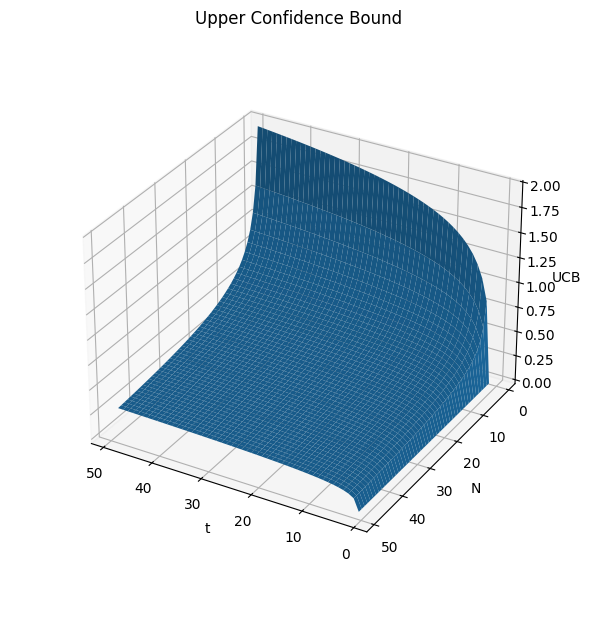

In [1]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(1, 50)
N = np.arange(1, 50)
t, N = np.meshgrid(t, N)
Z = np.sqrt(np.log(t) / N)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7.5,7.5))
ax.set_title("Upper Confidence Bound")
ax.plot_surface(t, N, Z, vmin=Z.min() * 2)
ax.set_xlabel("t")
ax.set_ylabel("N")
ax.set_zlabel("UCB")
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_box_aspect(None, zoom=0.85)

### $Exercise\ \mathcal{2.8}$*:* $UCB\ Spikes$

#### In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If $c=1$, then  the spike is less prominent.

For the first 10 steps, there is always at least one action $a$ for which $N_t(a)=0$, in which case it is considered a maximizing action. This means that all 10 actions have to be selected once in the first 10 steps. After this, $\forall a,\ N_t(a)=1$, so the UCB is the same for each action, and the action with the highest estimated value is chosen. This action is the most likely action to be optimal. After it is selected once, the UCB term again dominates action selection for the next steps, likely selection most, if not all other actions once more. When $c$ is reduced to 1, the UCB term's effect is less pronounced, lowering the extent of this effect.

## Gradient Bandit Algorithms

* Instead of learning the true action values, we can store a preference for each action
* Using the $softmax$ function, we can turn these preferences into probabilities $\pi_t(a)$
* After selecting an action, we can then update the preferences, using the average reward $\bar R_t$ as a baseline:

$$
\begin{align}
H_{t+1}(A_t)&\doteq H_t(A_t)+\alpha(R_t-\bar R_t)(1-\pi_t(A_t)),     &&\text{and} \\
H_{t+1}(a)  &\doteq H_t(a)-\alpha(R_t-\bar R_t)\pi_t(a),               &&\text{for all }a\neq A_t
\end{align}
$$

* This baseline enables instantly adjusting to rewards not centered around an initial estimate

### $Exercise\ \mathcal{2.9}$

#### Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.

For the softmax of two values, $x$ and $y$, and $z\doteq x-y$, we can see that
$$
\begin{align}
\operatorname{softmax}(x)&=\frac{e^x}{e^x+e^y} \\
&=\frac{e^x/e^y}{(e^x+e^y)/e^y} \\
&=\frac{e^{x-y}}{e^{x-y}+e^{y-y}} \\
&=\frac{e^z}{e^z+1} \\
&=\frac{1}{1+e^{-z}}.
\end{align}
$$
That is, we can shift the inputs to a softmax by a constant value, without changing the value of the softmax, and if this constant is one of the two input values, the softmax reduces to a sigmoid.

In the case of two actions $a_0$ and $a_1$, we can set $x=H_t(a_0)$, and $y=H_t(a_1)$, resulting in $\pi_t(a_0)=\sigma(z)$, and $\pi_t(a_1)=1-\sigma(z)$.

## Associative Search (Contextual Bandits)

* A step towards the full RL problem is $associative\ search$
* This is often called a $contextual\ bandit$ problem
* Facing multiple bandits at the same time, and learning separate value functions for each
* Step towards RL, because of multiple states
* Not all the way there, because actions don't affect future rewards (don't influence state transitions)

### $Exercise\ \mathcal{2.10}$

#### Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 10 and 20 with probability 0.5 (case A), and 90 and 80 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expected reward you can achieve and how should you behave to achieve it?

The expected rewards are
$$
\begin{align}
R_1&=0.5\cdot10+0.5\cdot90 \\
&=50 \\
&=0.5\cdot20+0.5\cdot80 \\
&=R_2,
\end{align}
$$
which means that the performance does not depend on the policy.

#### Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expected reward you can achieve in this task, and how should you behave to achieve it?

The associative search case is equivalent to solving two separate bandit problems simultaneously, keeping separate action value estimates for each. In this case, the expected reward is
$$
\begin{align}
R&=0.5\cdot R_A+0.5\cdot R_B \\
&=\frac{R_A+R_B}{2},
\end{align}
$$
where $R_A$ and $R_B$ are the expected rewards for case A and case B respectively. These depend on the performance of the algorithms used to solve each case. Assuming the optimal action is found for both problems, $R_A=20$ and $R_B=90$, so the optimal expected reward is
$$
\frac{R_A+R_B}{2}=\frac{20+90}{2}=\frac{110}{2}=55.
$$

### $Exercise\ \mathcal{2.11}\ (programming)$

#### Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\varepsilon$-greedy algorithm with $\alpha=0.1$. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.

Runs: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


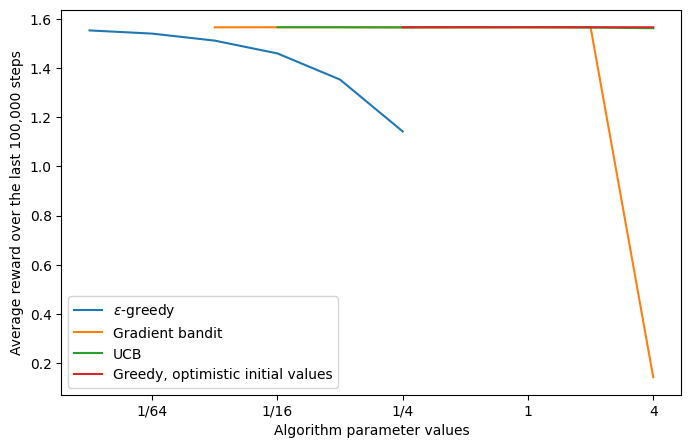

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as pls
from matplotlib.ticker import FuncFormatter, MultipleLocator
from fractions import Fraction

from bandits import *

epsilon = {
    "type": r"$\varepsilon$-greedy",
    "x": np.array([1/128, 1/64, 1/32, 1/16, 1/8, 1/4]),
}
epsilon["y"] = np.random.random(epsilon["x"].shape)
gradient = {
    "type": "Gradient bandit",
    "x": np.array([1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]),
}
gradient["y"] = np.random.random(gradient["x"].shape)
ucb = {
    "type": "UCB",
    "x": np.array([1/16, 1/8, 1/4, 1/2, 1, 2, 4]),
}
ucb["y"] = np.random.random(ucb["x"].shape)
greedy_optimist = {
    "type": "Greedy, optimistic initial values",
    "x": np.array([1/4, 1/2, 1, 2, 4]),
}
greedy_optimist["y"] = np.random.random(greedy_optimist["x"].shape)

steps = 200_000
runs = 1
k = 10
step_size = 0.1
drift = False
seed = np.random.randint(0, 2**32)

fig, ax = plt.subplots(figsize=(8,5))
for settings in [epsilon, gradient, ucb, greedy_optimist]:
    for i, param in enumerate(settings["x"]):
        averages = []
        for run in tqdm(range(runs), desc="Runs"):
            bandit = KArmedBandit(k, drift, seed=seed)
            match settings["type"]:
                case r"$\varepsilon$-greedy":
                    agent = EpsilonGreedyBanditAgent(k, param, step_size=step_size)
                case "Gradient bandit":
                    agent = GradientBanditAgent(k, r_step_size=0.1, step_size=param)
                case "UCB":
                    agent = UCBBanditAgent(k, param, step_size=step_size)
                case "Greedy, optimistic initial values":
                    agent = OptimisticGreedyBanditAgent(k, param, step_size=step_size)
            agent.learn(bandit, steps)
            averages.append(np.average(agent.rewards[steps // 2:]))
        settings["y"][i] = np.average(averages)
    
    ax.plot(settings["x"], settings["y"], label=settings["type"])

ax.set_xlabel("Algorithm parameter values")
ax.set_ylabel("Average reward over the last 100,000 steps")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: str(Fraction(x))))
ax.legend()
plt.show()